<a href="https://colab.research.google.com/github/jayrom/enterprise_challenge_reply/blob/main/sprint_3/src/reply_3_app.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análise de modelagem para manutenção preditiva

## Importar módulos

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import missingno as msno
from joblib import dump, load

## Dataset

### Carregar dataset

In [2]:
df = pd.read_csv("simulated_sensor_data.csv")

### Converter timestamp

In [3]:
# Converter a coluna 'timestamp' para o tipo datetime para facilitar a análise
df['timestamp'] = pd.to_datetime(df['timestamp'])

### Exibir dataset head

In [4]:
df.head()

,timestamp,device_id,temperature_c,current_amps,vibration_rms_g,days_to_failure,failure_mode
0,2025-06-30 05:03:52.374174,motor_1,46.64,6.08,0.28,-1,normal
1,2025-06-30 05:13:52.374174,motor_1,44.95,6.00,0.16,-1,normal
2,2025-06-30 05:23:52.374174,motor_1,48.24,5.98,0.27,-1,normal
3,2025-06-30 05:33:52.374174,motor_1,43.39,6.39,0.20,-1,normal
4,2025-06-30 05:43:52.374174,motor_1,43.81,5.93,0.19,-1,normal


### Exibir informações sobre o dataset

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17280 entries, 0 to 17279
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   timestamp        17280 non-null  datetime64[ns]
 1   device_id        17280 non-null  object        
 2   temperature_c    17280 non-null  float64       
 3   current_amps     17280 non-null  float64       
 4   vibration_rms_g  17280 non-null  float64       
 5   days_to_failure  17280 non-null  int64         
 6   failure_mode     17280 non-null  object        
dtypes: datetime64[ns](1), float64(3), int64(1), object(2)
memory usage: 945.1+ KB


### Exibir estatísticas básicas do dataframe original

In [6]:
df.describe()

,timestamp,temperature_c,current_amps,vibration_rms_g,days_to_failure
count,17280,17280.000000,17280.000000,17280.000000,17280.000000
mean,2025-07-30 04:58:52.411633664,46.812168,6.357642,0.432108,3.125000
min,2025-06-30 05:03:52.374174,37.180000,4.010000,0.070000,-1.000000
25%,2025-07-15 05:01:22.392903680,44.090000,5.760000,0.230000,-1.000000
50%,2025-07-30 04:58:52.411633408,45.720000,6.160000,0.270000,-1.000000
75%,2025-08-14 04:56:22.430363392,47.900000,6.682500,0.350000,-0.500000
max,2025-08-29 04:53:52.449093,64.560000,10.260000,1.800000,30.000000
std,NaN,4.302743,0.909251,0.383943,8.353447


## Limpeza dos dados

### Verificar dados faltantes

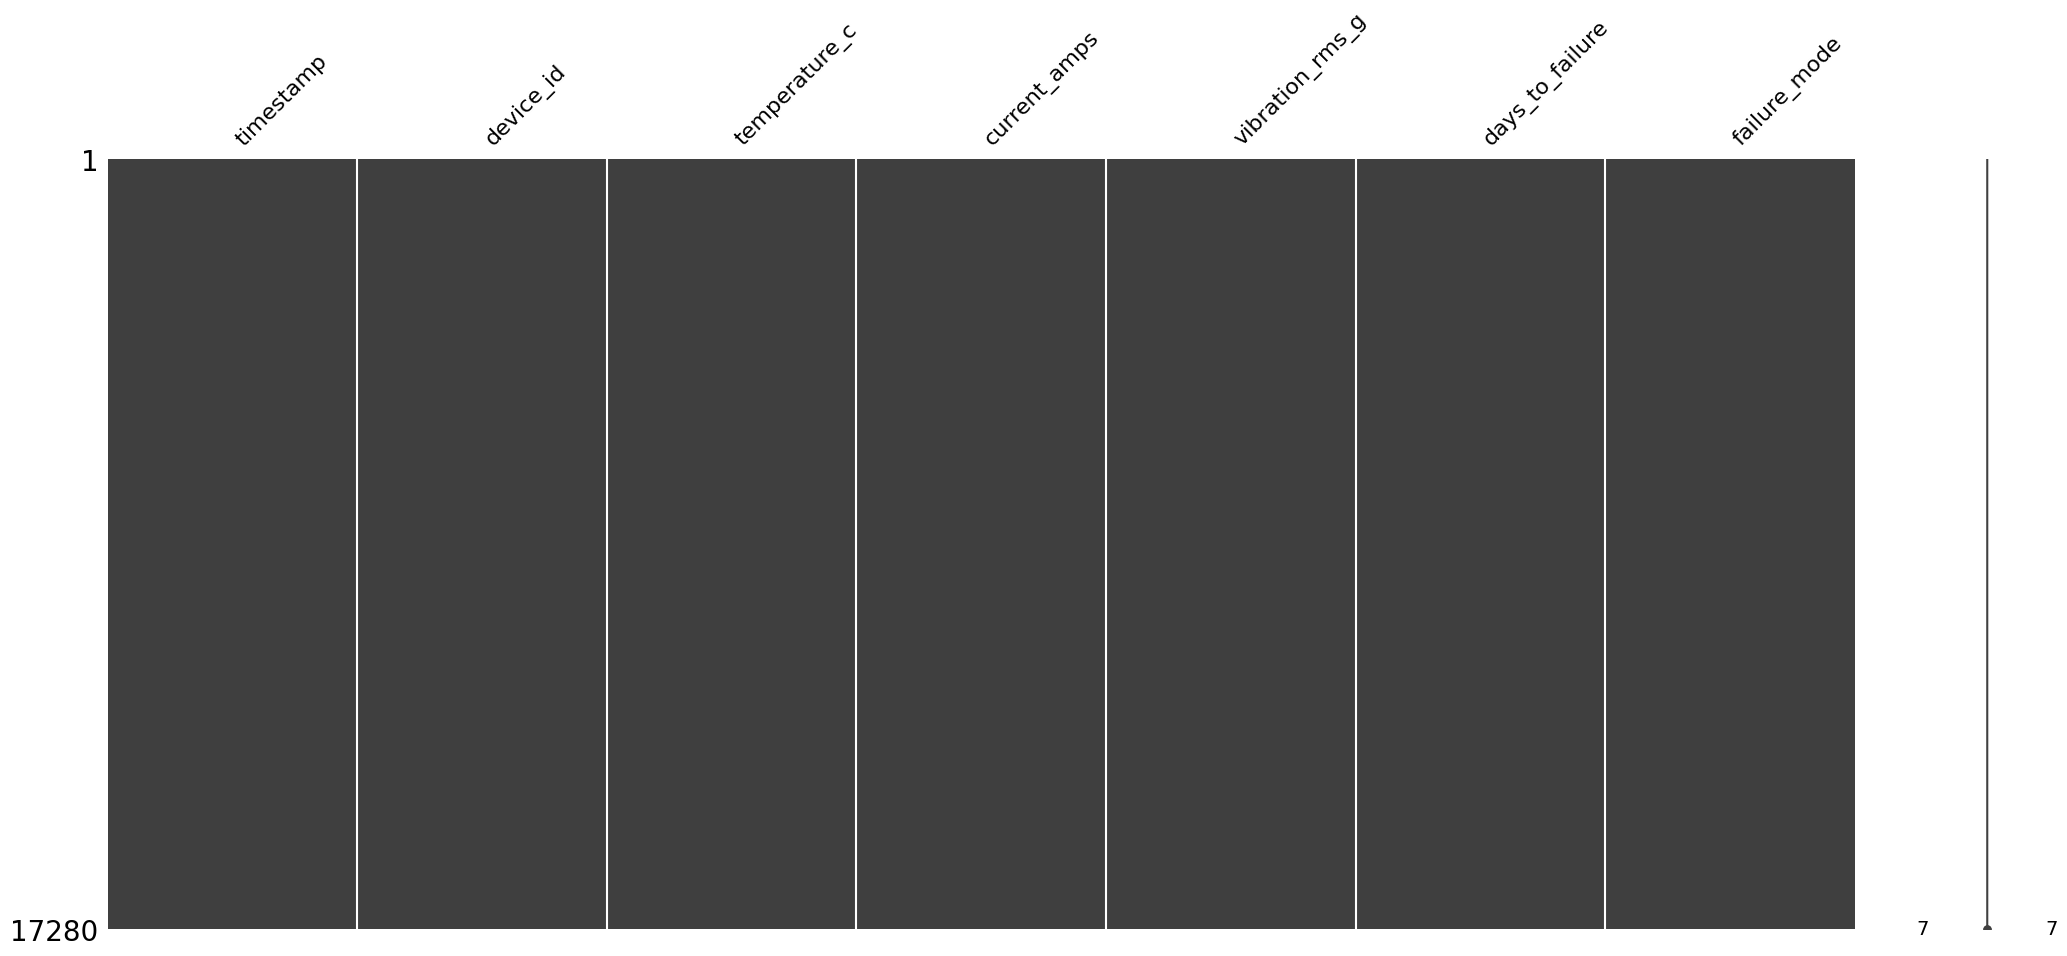

In [7]:
import missingno as msno
msno.matrix(df);

### Verificar dados duplicados

In [8]:
duplicates = df.duplicated().sum()
print("Número de dados duplicados:", duplicates)

Número de dados duplicados: 0


Remover duplicatas, se houver

In [9]:
df = df.drop_duplicates()

## Investigar outliers

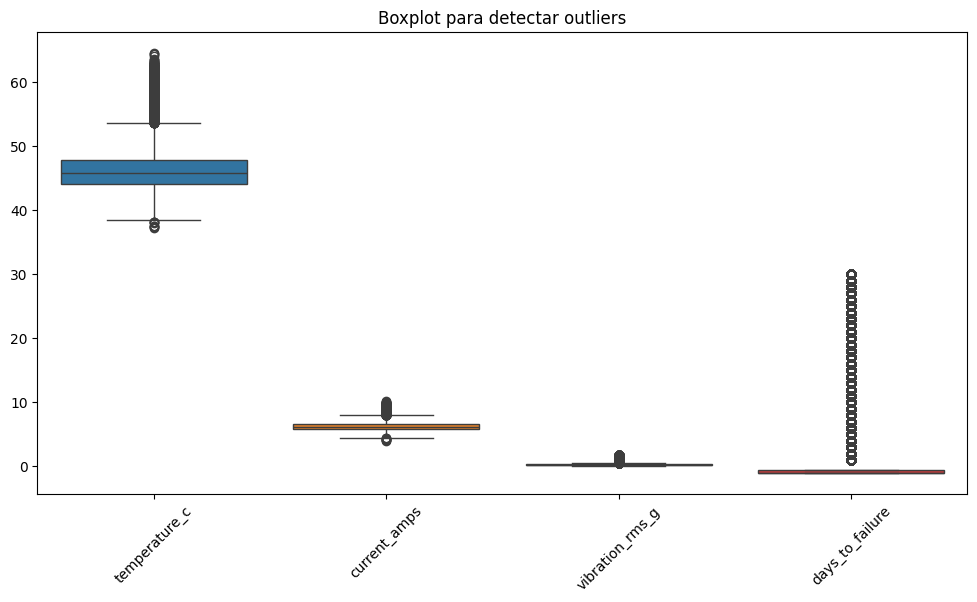

In [10]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df)
plt.title("Boxplot para detectar outliers")
plt.xticks(rotation=45)
plt.show()

#### Análise gráfica dos outliers

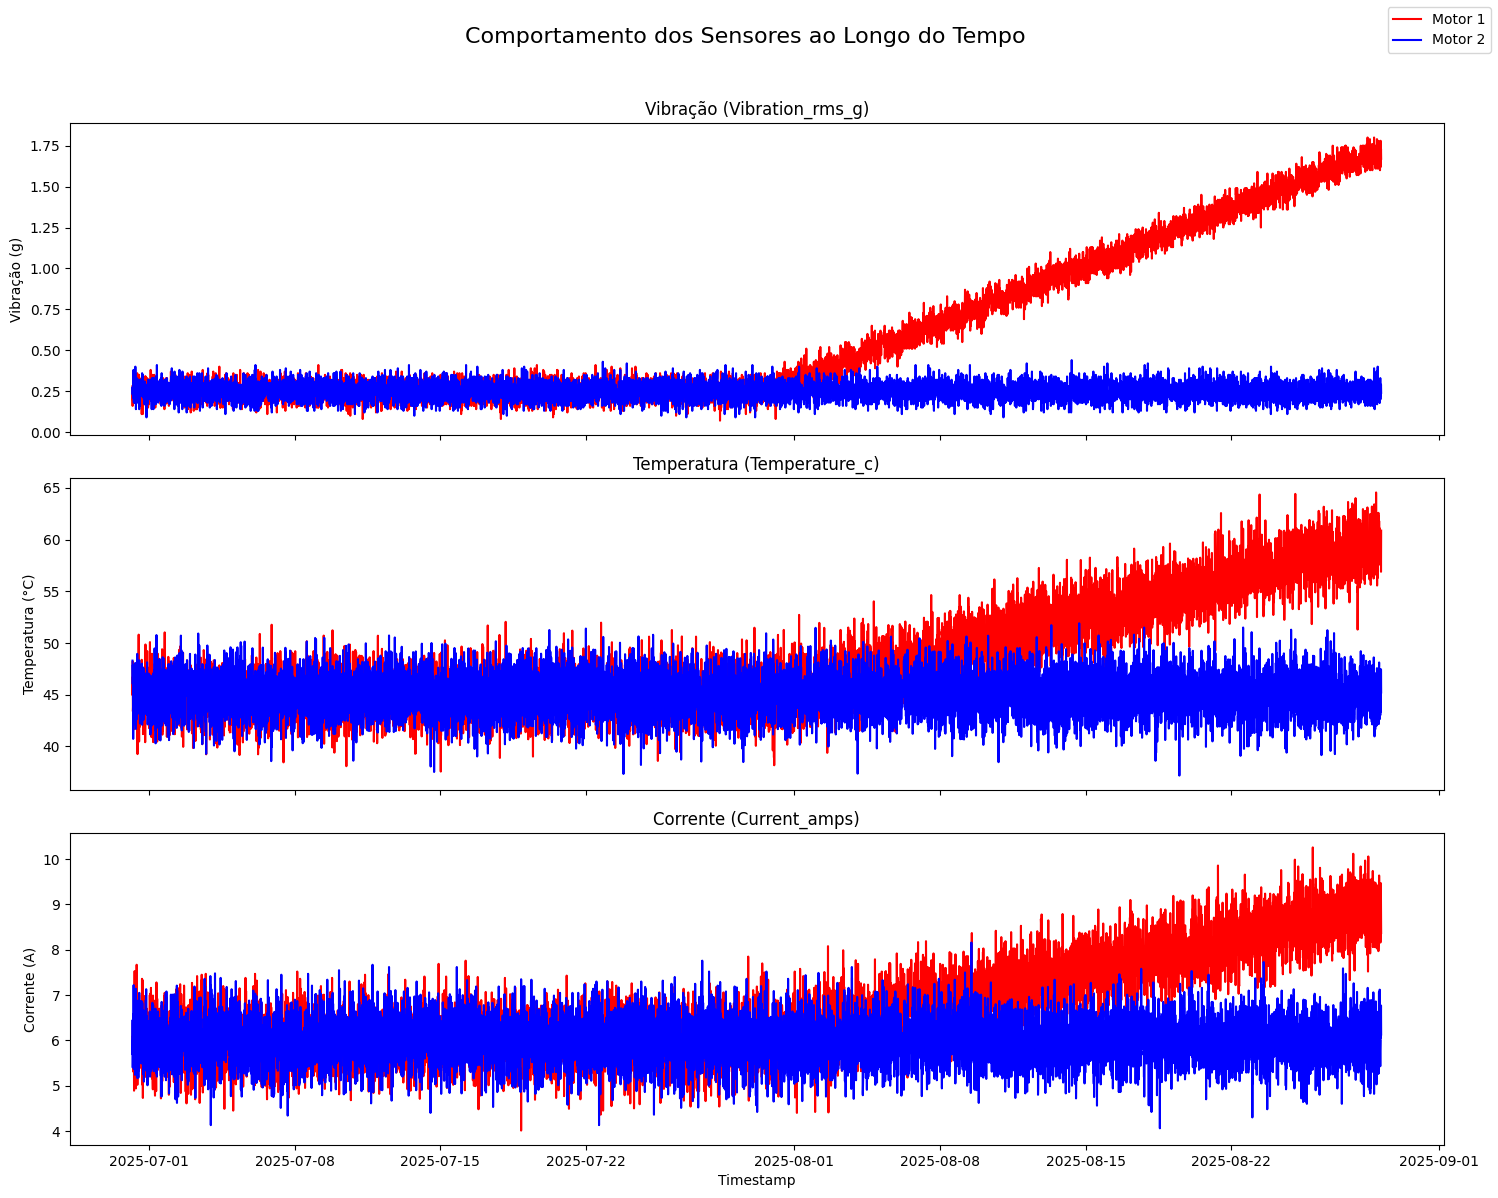

In [11]:
# Criar uma figura e eixos para os gráficos
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(15, 12), sharex=True)

# Plotar os dados para o motor_1
axes[0].plot(df[df['device_id'] == 'motor_1']['timestamp'], df[df['device_id'] == 'motor_1']['vibration_rms_g'], label='Motor 1', color='red')
axes[1].plot(df[df['device_id'] == 'motor_1']['timestamp'], df[df['device_id'] == 'motor_1']['temperature_c'], color='red')
axes[2].plot(df[df['device_id'] == 'motor_1']['timestamp'], df[df['device_id'] == 'motor_1']['current_amps'], color='red')

# Plotar os dados para o motor_2 (linha de base)
axes[0].plot(df[df['device_id'] == 'motor_2']['timestamp'], df[df['device_id'] == 'motor_2']['vibration_rms_g'], label='Motor 2', color='blue')
axes[1].plot(df[df['device_id'] == 'motor_2']['timestamp'], df[df['device_id'] == 'motor_2']['temperature_c'], color='blue')
axes[2].plot(df[df['device_id'] == 'motor_2']['timestamp'], df[df['device_id'] == 'motor_2']['current_amps'], color='blue')

# Adicionar títulos e rótulos
axes[0].set_title('Vibração (Vibration_rms_g)')
axes[1].set_title('Temperatura (Temperature_c)')
axes[2].set_title('Corrente (Current_amps)')
axes[2].set_xlabel('Timestamp')
axes[0].set_ylabel('Vibração (g)')
axes[1].set_ylabel('Temperatura (°C)')
axes[2].set_ylabel('Corrente (A)')
fig.suptitle('Comportamento dos Sensores ao Longo do Tempo', fontsize=16)

# Adicionar uma legenda e exibir o gráfico
fig.legend(loc='upper right')
plt.tight_layout(rect=[0, 0, 1, 0.96]) # Ajusta o layout para evitar sobreposição do título
plt.show()

Investigar correlação entre outliers e falha

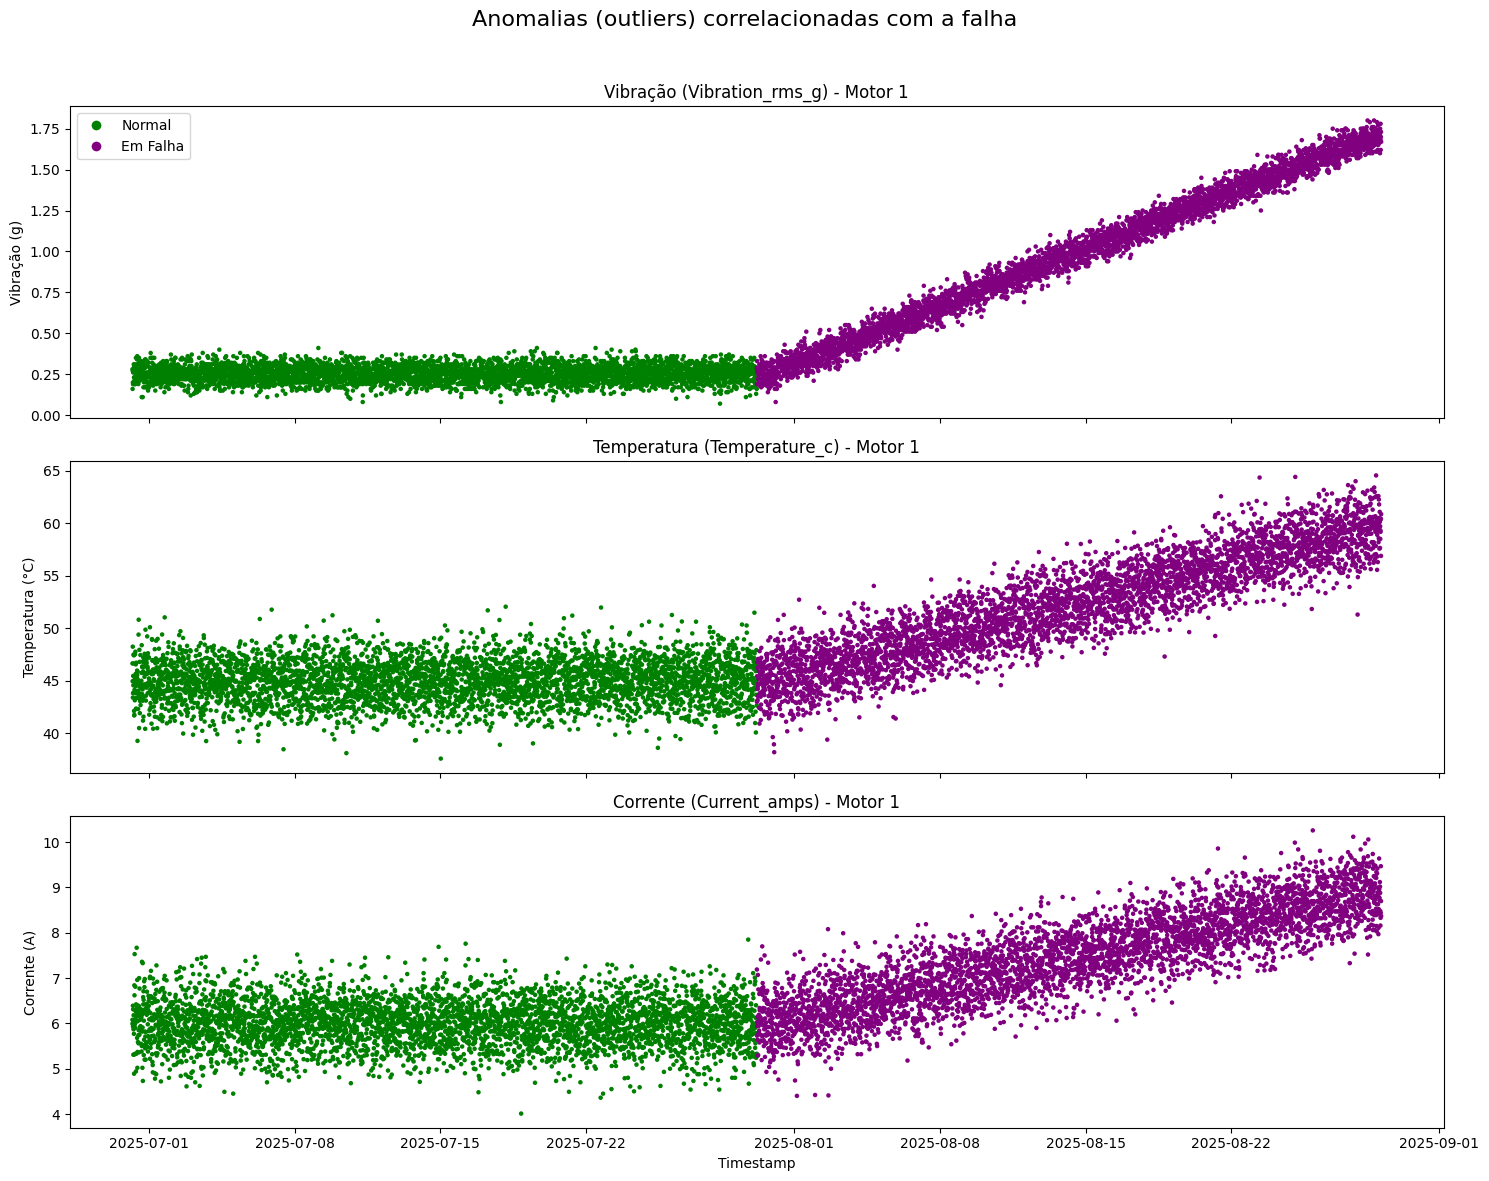

In [12]:
# Cópia do DataFrame original
df_plot = df.copy()

# Adicionar coluna 'status' para legenda
df_plot['status'] = 'Normal'
df_plot.loc[df_plot['days_to_failure'] != -1, 'status'] = 'Em Falha'

# Filtrar o DataFrame para o Motor 1 (o que falhou)
df_motor1 = df_plot[df_plot['device_id'] == 'motor_1']

# Criar figura para os gráficos
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(15, 12), sharex=True)

# Definir as cores com base no status
colors = df_motor1['status'].map({'Normal': 'green', 'Em Falha': 'purple'})

# Plotar os dados do Motor 1, colorindo por status
axes[0].scatter(df_motor1['timestamp'], df_motor1['vibration_rms_g'], c=colors, s=5)
axes[1].scatter(df_motor1['timestamp'], df_motor1['temperature_c'], c=colors, s=5)
axes[2].scatter(df_motor1['timestamp'], df_motor1['current_amps'], c=colors, s=5)

# Adicionar rótulos e títulos
axes[0].set_title('Vibração (Vibration_rms_g) - Motor 1')
axes[1].set_title('Temperatura (Temperature_c) - Motor 1')
axes[2].set_title('Corrente (Current_amps) - Motor 1')
axes[2].set_xlabel('Timestamp')
axes[0].set_ylabel('Vibração (g)')
axes[1].set_ylabel('Temperatura (°C)')
axes[2].set_ylabel('Corrente (A)')
fig.suptitle('Anomalias (outliers) correlacionadas com a falha', fontsize=16)

# Legenda
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Normal', markerfacecolor='green', markersize=8),
    Line2D([0], [0], marker='o', color='w', label='Em Falha', markerfacecolor='purple', markersize=8)
]
axes[0].legend(handles=legend_elements, loc='upper left')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Plot dos dados sem falhas

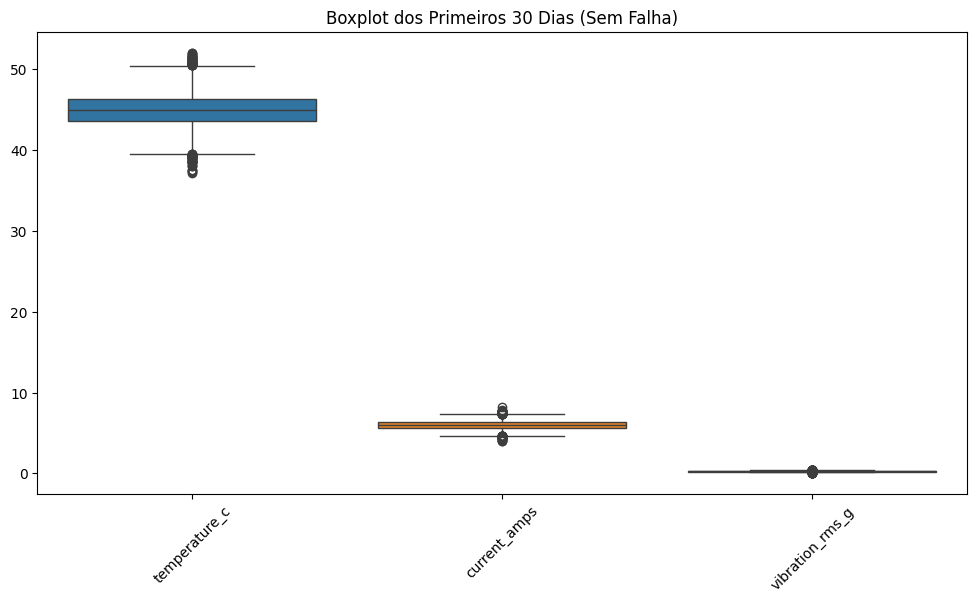

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Filtrar o DataFrame para os primeiros 30 dias de dados
df_first_30_days = df[df['days_to_failure'] == -1]

# start_date = df['timestamp'].min()
# end_date = start_date + pd.Timedelta(days=30)
# df_first_30_days = df[(df['timestamp'] >= start_date) & (df['timestamp'] < end_date)]


# Boxplot dos dados filtrados
plt.figure(figsize=(12, 6))

# Filtrar variáveis de dados dos sensores
columns_to_plot = ['temperature_c', 'current_amps', 'vibration_rms_g']
sns.boxplot(data=df_first_30_days[columns_to_plot])
plt.title("Boxplot dos Primeiros 30 Dias (Sem Falha)")
plt.xticks(rotation=45)
plt.show()

### Correlação entre as variáveis

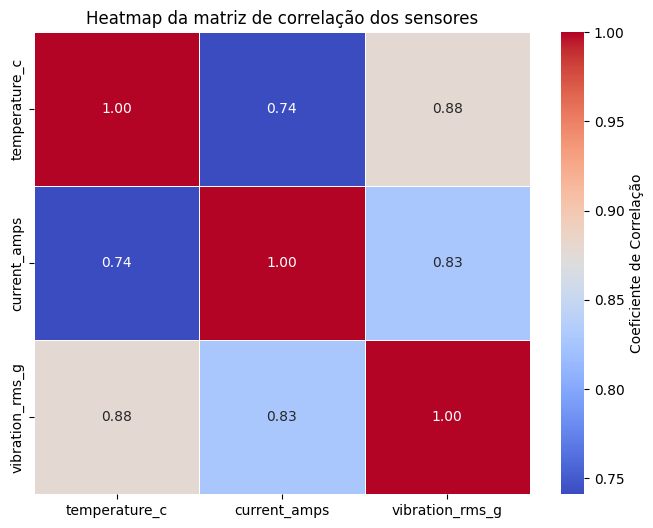

In [14]:
# Variáveis de interesse
sensor_data = df[['temperature_c', 'current_amps', 'vibration_rms_g']]

# Matriz de correlação
correlation_matrix = sensor_data.corr()

# Heatmap da correlação
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f",
            linewidths=.5, cbar_kws={'label': 'Coeficiente de Correlação'})

plt.title('Heatmap da matriz de correlação dos sensores')
plt.show()

## Modelagem

### Importar módulos

In [15]:
# Modelos de Regressão
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Modelos de Classificação
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Módulos de pré-processamento
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt

### Codificação

In [16]:
# Codificação da variável categórica 'device_id'
df_encoded = pd.get_dummies(df, columns=['device_id'], prefix='device')
df_encoded

,timestamp,temperature_c,current_amps,vibration_rms_g,days_to_failure,failure_mode,device_motor_1,device_motor_2
0,2025-06-30 05:03:52.374174,46.64,6.08,0.28,-1,normal,True,False
1,2025-06-30 05:13:52.374174,44.95,6.00,0.16,-1,normal,True,False
2,2025-06-30 05:23:52.374174,48.24,5.98,0.27,-1,normal,True,False
3,2025-06-30 05:33:52.374174,43.39,6.39,0.20,-1,normal,True,False
4,2025-06-30 05:43:52.374174,43.81,5.93,0.19,-1,normal,True,False
...,...,...,...,...,...,...,...,...
17275,2025-08-29 04:13:52.449093,45.25,6.05,0.25,-1,normal,False,True
17276,2025-08-29 04:23:52.449093,46.69,6.40,0.26,-1,normal,False,True
17277,2025-08-29 04:33:52.449093,43.36,6.26,0.26,-1,normal,False,True
17278,2025-08-29 04:43:52.449093,47.44,6.77,0.29,-1,normal,False,True


### Features e pré-processamento

In [17]:
# Indicar features
features_encoded = ['temperature_c', 'current_amps', 'vibration_rms_g', 'device_motor_1', 'device_motor_2']
X = df_encoded[features_encoded]
y_reg = df_encoded['days_to_failure']

# Pré-processamento e normalização das features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Exportar o scaler para uso em preições posteriores
dump(scaler, 'scaler.joblib')

['scaler.joblib']

## Modelos de regressão<br /><sub>(predição da vida útil restante)</sub>

In [18]:
y_reg = df['days_to_failure']

# Dados de treino e teste
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_scaled, y_reg, test_size=0.3, random_state=42)

### Regressão linear

In [19]:
# Treinamento
print("\nTreinando Regressão Linear")
lr_model = LinearRegression()
lr_model.fit(X_train_reg, y_train_reg)
y_pred_lr = lr_model.predict(X_test_reg)

# Avaliação
print("\nAvaliação do modelo de Regressão Linear")
mse_lr = mean_squared_error(y_test_reg, y_pred_lr)
r2_lr = r2_score(y_test_reg, y_pred_lr)
print(f"MSE (Erro Quadrático Médio) - Regressão Linear: {mse_lr:.2f}")
print(f"R² (Coeficiente de Determinação) - Regressão Linear: {r2_lr:.2f}")

# Salvar o modelo treinado
dump(lr_model, 'linear_regression_model.joblib')


Treinando Regressão Linear

Avaliação do modelo de Regressão Linear
MSE (Erro Quadrático Médio) - Regressão Linear: 49.52
R² (Coeficiente de Determinação) - Regressão Linear: 0.28


['linear_regression_model.joblib']

### Regressão Random Forest

In [20]:
# Treinamento
print("\nTreinando Random Forest Regressor")
rf_reg_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_reg_model.fit(X_train_reg, y_train_reg)
y_pred_rf_reg = rf_reg_model.predict(X_test_reg)

# Avaliação
mse_rf = mean_squared_error(y_test_reg, y_pred_rf_reg)
r2_rf = r2_score(y_test_reg, y_pred_rf_reg)
print(f"MSE (Erro Quadrático Médio) - Random Forest: {mse_rf:.2f}")
print(f"R² (Coeficiente de Determinação) - Random Forest: {r2_rf:.2f}")

# Salvar o modelo treinado
dump(rf_reg_model, 'random_forest_regressor_model.joblib')


Treinando Random Forest Regressor
MSE (Erro Quadrático Médio) - Random Forest: 20.86
R² (Coeficiente de Determinação) - Random Forest: 0.70


['random_forest_regressor_model.joblib']

## Modelos de classificação<br /><sub>(detecção de falha)</sub>

In [21]:
# Codificar 'failure_mode'
le = LabelEncoder()
y_class = le.fit_transform(df_encoded['failure_mode'])

# Dados de treino e teste
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(X_scaled, y_class, test_size=0.3, random_state=42)

# Salvar o LabelEncoder, para converter predições numéricas de volta para texto
dump(le, 'label_encoder.joblib')

['label_encoder.joblib']

### Regressão Logística


Treinando Regressão Logística
Acurácia - Regressão Logística: 0.98

Relatório de Classificação:
                     precision    recall  f1-score   support

             normal       0.99      0.91      0.95      1313
failure_in_progress       0.97      1.00      0.98      3871

           accuracy                           0.98      5184
          macro avg       0.98      0.95      0.97      5184
       weighted avg       0.98      0.98      0.97      5184


Matriz de Confusão - Regressão Logística:
[[1198  115]
 [  14 3857]]


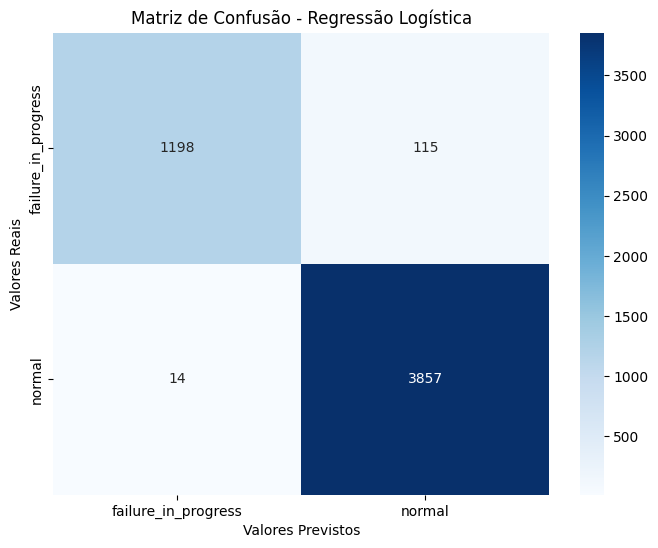

['logistic_regression_model.joblib']

In [22]:
# Treinamento
print("\nTreinando Regressão Logística")
log_reg_model = LogisticRegression(random_state=42)
log_reg_model.fit(X_train_class, y_train_class)
y_pred_log_reg = log_reg_model.predict(X_test_class)

# Avaliação
accuracy_log_reg = accuracy_score(y_test_class, y_pred_log_reg)
print(f"Acurácia - Regressão Logística: {accuracy_log_reg:.2f}")
print("\nRelatório de Classificação:")
print(classification_report(y_test_class, y_pred_log_reg, target_names=df['failure_mode'].unique()))

# Matriz de Confusão
cm_log_reg = confusion_matrix(y_test_class, y_pred_log_reg)
print("\nMatriz de Confusão - Regressão Logística:")
print(cm_log_reg)

# Heatmap da Matriz de Confusão
plt.figure(figsize=(8, 6))
sns.heatmap(cm_log_reg, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Matriz de Confusão - Regressão Logística')
plt.ylabel('Valores Reais')
plt.xlabel('Valores Previstos')
plt.show()

# Salvar o modelo treinado
dump(log_reg_model, 'logistic_regression_model.joblib')

### Support Vector Machine (SVM)


Treinando SVM
Acurácia - SVM: 0.98

Relatório de Classificação:
                     precision    recall  f1-score   support

             normal       1.00      0.91      0.95      1313
failure_in_progress       0.97      1.00      0.98      3871

           accuracy                           0.98      5184
          macro avg       0.98      0.95      0.97      5184
       weighted avg       0.98      0.98      0.98      5184


Matriz de Confusão - SVM:
[[1192  121]
 [   5 3866]]


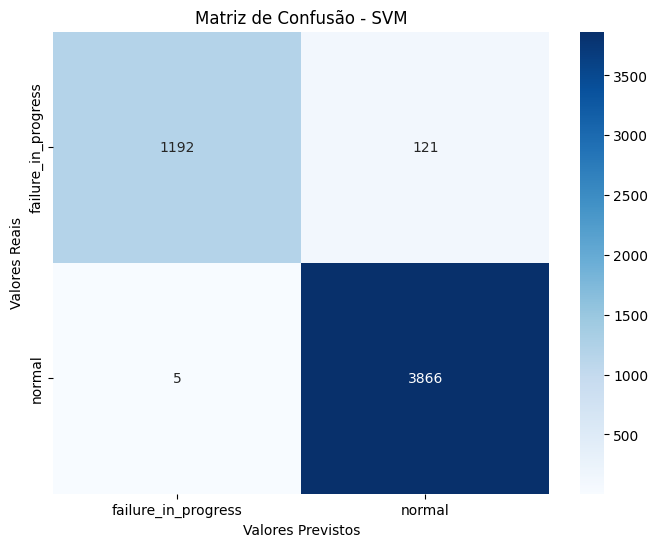

['svm_model.joblib']

In [23]:
# Treinamento
print("\nTreinando SVM")
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train_class, y_train_class)
y_pred_svm = svm_model.predict(X_test_class)

# Avaliação
accuracy_svm = accuracy_score(y_test_class, y_pred_svm)
print(f"Acurácia - SVM: {accuracy_svm:.2f}")
print("\nRelatório de Classificação:")
print(classification_report(y_test_class, y_pred_svm, target_names=df['failure_mode'].unique()))

# Matriz de confusão
cm_svm = confusion_matrix(y_test_class, y_pred_svm)
print("\nMatriz de Confusão - SVM:")
print(cm_svm)

# Heatmap da matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Matriz de Confusão - SVM')
plt.ylabel('Valores Reais')
plt.xlabel('Valores Previstos')
plt.show()

# Salvar o modelo treinado
dump(svm_model, 'svm_model.joblib')

## Uso dos modelos

In [24]:
# Exemplo uso do modelo treinado
print("\nExemplo uso do modelo treinado")
import numpy as np

# Dados de um novo ponto do motor em falha (valores elevados)
new_data_point = np.array([[55.0, 7.5, 0.8, True, False]]) # Added device_motor_1 and device_motor_2 features
new_data_point_scaled = scaler.transform(new_data_point)

print(f"Dados puros: {new_data_point}")

print(f"\nDados de leitura")
print("----------------\n")

print(f"Temperatura: {new_data_point[0][0]} °C")
print(f"Corrente: {new_data_point[0][1]} A")
print(f"Vibração: {new_data_point[0][2]} g")

device = "motor_1" if new_data_point[0][3] else "motor_2"
print(f"Dispositivo: {device}\n")

print(f"Dados padronizados: {new_data_point_scaled}\n")


print(f"\nPredições")
print("---------\n")


# Predição de Regressão (Random Forest)
predicted_days_to_failure = rf_reg_model.predict(new_data_point_scaled)
print(f"Vida Útil Restante (RF Regressor): Aproximadamente {predicted_days_to_failure[0]:.2f} dias")

# Predição de Classificação (Regressão Logística)
predicted_class = log_reg_model.predict(new_data_point_scaled)
predicted_label = predicted_class # The prediction is already a string in this case

status = "normal" if predicted_label[0] == 0 else "em falha"
print(f"Classificação (Regressão Logística): O estado do motor é '{status}'")


Exemplo uso do modelo treinado
Dados puros: [[55.   7.5  0.8  1.   0. ]]

Dados de leitura
----------------

Temperatura: 55.0 °C
Corrente: 7.5 A
Vibração: 0.8 g
Dispositivo: motor_1

Dados padronizados: [[ 1.90298801  1.25640891  0.95822227  1.         -1.        ]]


Predições
---------

Vida Útil Restante (RF Regressor): Aproximadamente 18.43 dias
Classificação (Regressão Logística): O estado do motor é 'normal'
